# HST binary image classifier - satellite vs no satellite

---

*Ben Aussel, November 2021, ESA*

---

## Modules

In [3]:
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import pandas as pd
from pandas.core.common import flatten
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Connection to Weight and Biases (https://wandb.ai)
#import wandb
#from wandb.keras import WandbCallback

# Predictions for single images

Test the classifier by setting the filepath to a Hubble image. An examples was added.

In [16]:
#Enter image path here
image_path = "prediction_images/ieea17020_ieea17ruq.jpg"

In [21]:
#Load model
model = tf.keras.models.load_model("weights/model.22.h5")
model.summary()
class_names = ["no_satellite","satellite"]
class_threshold = 0.5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 600, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 17, 17, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [ ]:
#Load image and show it
im = PIL.Image.open(image_path).convert("RGB")
im = im.resize((600,600))
plt.figure(figsize=(6,6))
plt.imshow(im,cmap="gist_gray")
plt.axis("off")

#Process the image to an array and then to a batch
img_array = keras.preprocessing.image.img_to_array(im)
img_array = tf.expand_dims(img_array, 0) #Create a batch

#Calculate the (binary) prediction
score = model.predict(img_array)
class_pr = (score > class_threshold).astype("int32") #For binary prediction
if class_pr == 0:
    score = 1 - score

#Print the result
print("This image most likely belongs to {} with a {:.2f}% confidence."
      .format(class_names[int(class_pr)], 100 *float(score)))

# Code used for the training of the model and the predictions

Results can be reproduced by entering the images to the "training_images" and "prediction_images" folders.

## Data Preparation

In [ ]:
#Paramters for the images
img_height = 600
img_width = 600

#Batch_size - Size of used images per step
batch_size = 10

#Image Path
image_path = "training_images/"

#Class Threshold
class_threshold = 0.5

In [ ]:
#Definition of the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split = 0.2,
    subset = "training",
    seed = 789,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = "binary")

Found 5951 files belonging to 2 classes.
Using 4761 files for training.


In [ ]:
#Definition of the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  validation_split= 0.2 ,
  subset = "validation",
  seed = 789,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = "binary")

Found 5951 files belonging to 2 classes.
Using 1190 files for validation.


In [ ]:
#Return the class names
class_names = train_ds.class_names
print("Classes:",class_names)

Classes: ['no_satellite', 'satellite']


In [ ]:
print("Shape of the Dataset:")
print(train_ds)

Shape of the Dataset:
<BatchDataset shapes: ((None, 600, 600, 3), (None, 1)), types: (tf.float32, tf.float32)>


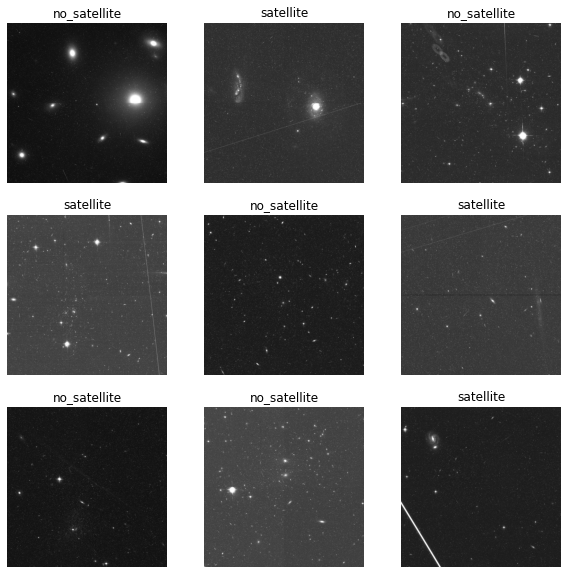

In [ ]:
#Example Images
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1): #Takes the first batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

## Creating the model

Using the Inceptionv3 model

In [ ]:
#Use the existing InceptionV3 model for this classification
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Save the model and load the downloaded weights (no top because layer specific for imagenet competition)
pre_trained_model = InceptionV3(
    input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

#Set the model to trainable
for layer in pre_trained_model.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#Learning rate
learn_rate = 0.0005

In [ ]:
#Definition of the layers of the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  pre_trained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation = 'relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation = 'relu'),
  layers.Dropout(0.5),
  layers.Dense(32, activation = 'relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Compiling of the model, loss function is binary
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learn_rate),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
                         #tf.keras.metrics.BinaryAccuracy(threshold=class_threshold)])

In [ ]:
#Overview over the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 600, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 17, 17, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

## Training

In [ ]:
#Connection to Weights and Biases
#parameters
config = wandb.config
config.learning_rate = learn_rate
wandb.init(project = 'image_classifier')

my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}.h5'),
    WandbCallback()]

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Number_of_run
number_run = "100"

In [ ]:
#Number of epochs for the training
epoch_number = 50

#Starting the training and storing the result in 'history'
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epoch_number,
  callbacks = my_callbacks)

Epoch 1/50
477/477 [==============================] - 329s 636ms/step - loss: 0.7208 - accuracy: 0.5028 - val_loss: 0.6877 - val_accuracy: 0.5454
Epoch 2/50
477/477 [==============================] - 171s 358ms/step - loss: 0.7006 - accuracy: 0.5188 - val_loss: 0.6782 - val_accuracy: 0.5479
Epoch 3/50
477/477 [==============================] - 171s 358ms/step - loss: 0.6911 - accuracy: 0.5469 - val_loss: 0.6745 - val_accuracy: 0.5496
Epoch 4/50
477/477 [==============================] - 171s 357ms/step - loss: 0.6841 - accuracy: 0.5610 - val_loss: 0.6713 - val_accuracy: 0.5521
Epoch 5/50
477/477 [==============================] - 171s 358ms/step - loss: 0.6761 - accuracy: 0.5673 - val_loss: 0.6639 - val_accuracy: 0.5723
Epoch 6/50
477/477 [==============================] - 171s 357ms/step - loss: 0.6679 - accuracy: 0.6043 - val_loss: 0.6464 - val_accuracy: 0.6496
Epoch 7/50
477/477 [==============================] - 171s 358ms/step - loss: 0.6466 - accuracy: 0.6356 - val_loss: 0.6077 -

In [ ]:
# Save the entire model to a HDF5 file.
model_save_path = "/content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/"
model.save(model_save_path+"Image_Classifier_"+str(number_run)) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/Image_Classifier_100/assets


### Confusion matrix

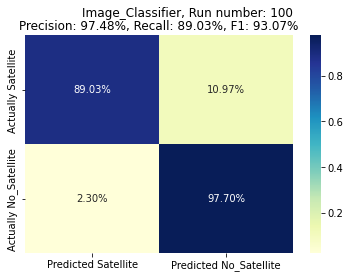

In [ ]:
model = tf.keras.models.load_model("weights/model.22.h5")
class_threshold = 0.5

#Extract labels and predictions for validation data of the model
y_pred_list = []
y_real_list = []
for images, labels in val_ds:
    #Prediction
    class_pr = (model.predict(images) > class_threshold).astype("int32")
    y_pred_list.append(class_pr)
    #Label
    lab = list(np.ndarray.flatten(labels.numpy()))
    y_real_list.append(int(item) for item in lab)
y_real = list(flatten(y_real_list))
y_pred = list(flatten(y_pred_list))

#Calculates the values of the matrix
confusion_matrix_scores = confusion_matrix(y_real, y_pred, labels=[1, 0], normalize = "true")

#Extract true/false positive/negative values
tp, fn, fp, tn = confusion_matrix_scores.ravel()

#Calculate precision and recall + F1 score
precision = tp / (tp + fp)
recall =  tp / (tp + fn)
F1 = 2 * precision * recall / (precision + recall)

#Draw and show the matrix
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Satellite", "Predicted No_Satellite"],
                  index = ["Actually Satellite", "Actually No_Satellite"])
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2%")
plt.suptitle("Image_Classifier, Run number: 100")
plt.title("Precision: {:.2%}, Recall: {:.2%}, F1: {:.2%}".format(precision,recall,F1))
plt.savefig("/content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/Image_Classifier_100/confusion_matrix_epoch_22.pdf",bbox_inches='tight')
plt.show()

### Predictions for image from Hubble Archive

In [ ]:
#Load model
model = tf.keras.models.load_model("weights/model.22.h5")
model.summary()
class_names = ["no_satellite","satellite"]
class_threshold = 0.5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 600, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 17, 17, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [ ]:
# image folder
folder_path = "predictions_images/"

# dimensions of images
img_width, img_height = 600, 600

predictions, error_ids = [], []

i = 0
for img in tqdm(os.listdir(folder_path)):
    img_p = os.path.join(folder_path, img)
    try:
        img_p = image.load_img(img_p, target_size=(img_width, img_height))
    except:
        error_ids.append(img)
        continue
    img_p = image.img_to_array(img_p)
    img_p = np.expand_dims(img_p, axis=0)
    score = model.predict(img_p)
    class_pr = (score > class_threshold).astype("int32")
    ids = str(img)
    if class_pr == 0:
        pred = "no_satellite"
    else:
        pred = "satellite"
    predictions.append([ids,pred,str(score[0][0])])
    if i == 20000 or i == 40000 or i == 60000 or i == 80000:
        print("Saved, i =", i)
        data = pd.DataFrame(predictions,columns=["filename","prediction","score"])
        data.to_csv("satellites"+str(i)+".csv")
    i = i + 1

100%|██████████| 1968/1968 [26:59<00:00,  1.22it/s]


In [ ]:
data = pd.DataFrame(predictions,columns=["filename","prediction","score"])
data.to_csv(pathout+"satellites.csv")
data
data_error = pd.DataFrame(error_ids,columns=["error_id"])
data_error.to_csv(pathout+"satellites_errors.csv")